In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, re, datetime, random, gzip, json, copy
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
PROJ_PATH = Path(os.path.join(re.sub("/TS-IDS.*$", '', os.getcwd()), 'TS-IDS'))
import warnings
warnings.filterwarnings('ignore')

# EDA

In [2]:
cat_cnames = ['TCP_FLAGS','L7_PROTO','PROTOCOL']

## NF-BoT-IoT

In [5]:
dataset_name = 'NF-BoT-IoT' # 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}.csv'))
data['IPV4_SRC_FULL_ADDR'] = data['IPV4_SRC_ADDR'].astype(str) + ':' + data['L4_SRC_PORT'].astype(str)
data['IPV4_DST_FULL_ADDR'] = data['IPV4_DST_ADDR'].astype(str) + ':' + data['L4_DST_PORT'].astype(str)
print('Number of samples:', data.shape[0])

Number of samples: 600100


In [6]:
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_FULL_ADDR,IPV4_DST_FULL_ADDR
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign,192.168.100.6:52670,192.168.100.1:53
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft,192.168.100.6:49160,192.168.100.149:4444
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign,192.168.100.46:3456,192.168.100.5:80
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign,192.168.100.3:80,192.168.100.55:8080
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign,192.168.100.46:80,192.168.100.5:80


In [7]:
for cname in cat_cnames:
    print(cname, data[cname].nunique())

TCP_FLAGS 23
L7_PROTO 89
PROTOCOL 3


In [8]:
print(data['Label'].value_counts())
print(data['Attack'].value_counts())

1    586241
0     13859
Name: Label, dtype: int64
Reconnaissance    470655
DDoS               56844
DoS                56833
Benign             13859
Theft               1909
Name: Attack, dtype: int64


In [5]:
src_ip = data['IPV4_SRC_ADDR'].unique().tolist()
dst_ip = data['IPV4_DST_ADDR'].unique().tolist()
intersection_ip = set(src_ip).intersection(set(dst_ip))
print('Number of src:', len(src_ip))
print('Number of dst:', len(dst_ip))
print('Number of intersections:', len(intersection_ip))

Number of src: 15
Number of dst: 129
Number of intersections: 13


In [9]:
src_port = data['L4_SRC_PORT'].unique().tolist()
dst_port = data['L4_DST_PORT'].unique().tolist()
intersection_port = set(src_port).intersection(set(dst_port))
print('Number of src:', len(src_port))
print('Number of dst:', len(dst_port))
print('Number of intersections:', len(intersection_port))

Number of src: 25938
Number of dst: 12698
Number of intersections: 6418


In [10]:
src_ip = data['IPV4_SRC_FULL_ADDR'].unique().tolist()
dst_ip = data['IPV4_DST_FULL_ADDR'].unique().tolist()
intersection_ip = set(src_ip).intersection(set(dst_ip))
print('Number of src:', len(src_ip))
print('Number of dst:', len(dst_ip))
print('Number of intersections:', len(intersection_ip))

Number of src: 64488
Number of dst: 16304
Number of intersections: 3615


In [18]:
df_src = data.pivot_table(
    index='IPV4_SRC_ADDR', columns=['Label'], values='IPV4_DST_ADDR', aggfunc='count').fillna(0)
df_src['Total'] = df_src.sum(axis=1)
for c in df_src.columns:
    if c!='Total':
        df_src[c] = df_src[c] / df_src['Total']
df_src.sort_values('Total', ascending=False).head(20)

Label,0,1,Total
IPV4_SRC_ADDR,,,
192.168.100.148,0.012408,0.987592,171096.0
192.168.100.149,0.010660,0.989340,151784.0
192.168.100.147,0.014699,0.985301,145998.0
192.168.100.150,0.017952,0.982048,118985.0
192.168.100.3,0.200877,0.799123,5471.0
192.168.100.7,0.799654,0.200346,4043.0
192.168.100.5,0.266871,0.733129,978.0
192.168.100.6,0.405213,0.594787,844.0
192.168.100.46,1.000000,0.000000,764.0


In [19]:
np.percentile(df_src['Total'], range(0, 101, 10)).round(2)

array([1.000000e+00, 9.800000e+00, 2.460000e+01, 3.420000e+01,
       4.820000e+02, 8.440000e+02, 2.204000e+03, 5.185400e+03,
       1.243876e+05, 1.494696e+05, 1.710960e+05])

In [12]:
df_src = data.pivot_table(
    index='IPV4_SRC_ADDR', columns=['Attack'], values='IPV4_DST_ADDR', aggfunc='count').fillna(0)
df_src['Total'] = df_src.sum(axis=1)
for c in df_src.columns:
    if c!='Total':
        df_src[c] = df_src[c] / df_src['Total']
df_src.sort_values('Total', ascending=False).head(20)

Attack,Benign,DDoS,DoS,Reconnaissance,Theft,Total
IPV4_SRC_ADDR,,,,,,
192.168.100.148,0.012408,0.130412,0.130412,0.726767,0.000000,171096.0
192.168.100.149,0.010660,0.108523,0.108523,0.770154,0.002141,151784.0
192.168.100.147,0.014699,0.094864,0.094864,0.795573,0.000000,145998.0
192.168.100.150,0.017952,0.029029,0.029029,0.921713,0.002278,118985.0
192.168.100.3,0.200877,0.075489,0.070188,0.418205,0.235240,5471.0
192.168.100.7,0.799654,0.012367,0.016819,0.171160,0.000000,4043.0
192.168.100.5,0.266871,0.219836,0.219836,0.293456,0.000000,978.0
192.168.100.6,0.405213,0.091232,0.091232,0.381517,0.030806,844.0
192.168.100.46,1.000000,0.000000,0.000000,0.000000,0.000000,764.0


In [14]:
df_src = data.pivot_table(
    index='IPV4_SRC_FULL_ADDR', columns=['Attack'], values='IPV4_DST_FULL_ADDR', aggfunc='count').fillna(0)
df_src['Total'] = df_src.sum(axis=1)
for c in df_src.columns:
    if c!='Total':
        df_src[c] = df_src[c] / df_src['Total']
df_src.sort_values('Total', ascending=False).head(20)

Attack,Benign,DDoS,DoS,Reconnaissance,Theft,Total
IPV4_SRC_FULL_ADDR,,,,,,
192.168.100.148:40850,0.000000,0.000239,0.000239,0.999522,0.000000,8361.0
192.168.100.3:0,0.000748,0.285714,0.285714,0.285714,0.142109,1337.0
192.168.100.7:3306,0.581633,0.000000,0.000000,0.418367,0.000000,1078.0
192.168.100.148:46217,0.000000,0.000965,0.000965,0.998069,0.000000,1036.0
192.168.100.148:58684,0.000000,0.004941,0.004941,0.990119,0.000000,1012.0
192.168.100.147:51908,0.000000,0.003956,0.003956,0.992087,0.000000,1011.0
192.168.100.148:33682,0.000000,0.003960,0.003960,0.992079,0.000000,1010.0
192.168.100.148:38830,0.000000,0.002973,0.002973,0.994054,0.000000,1009.0
192.168.100.148:33410,0.000991,0.002973,0.002973,0.993062,0.000000,1009.0


In [17]:
np.percentile(df_src['Total'], range(0, 101, 10)).round(2)

array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
       3.000e+00, 4.000e+00, 6.000e+00, 7.000e+00, 8.361e+03])

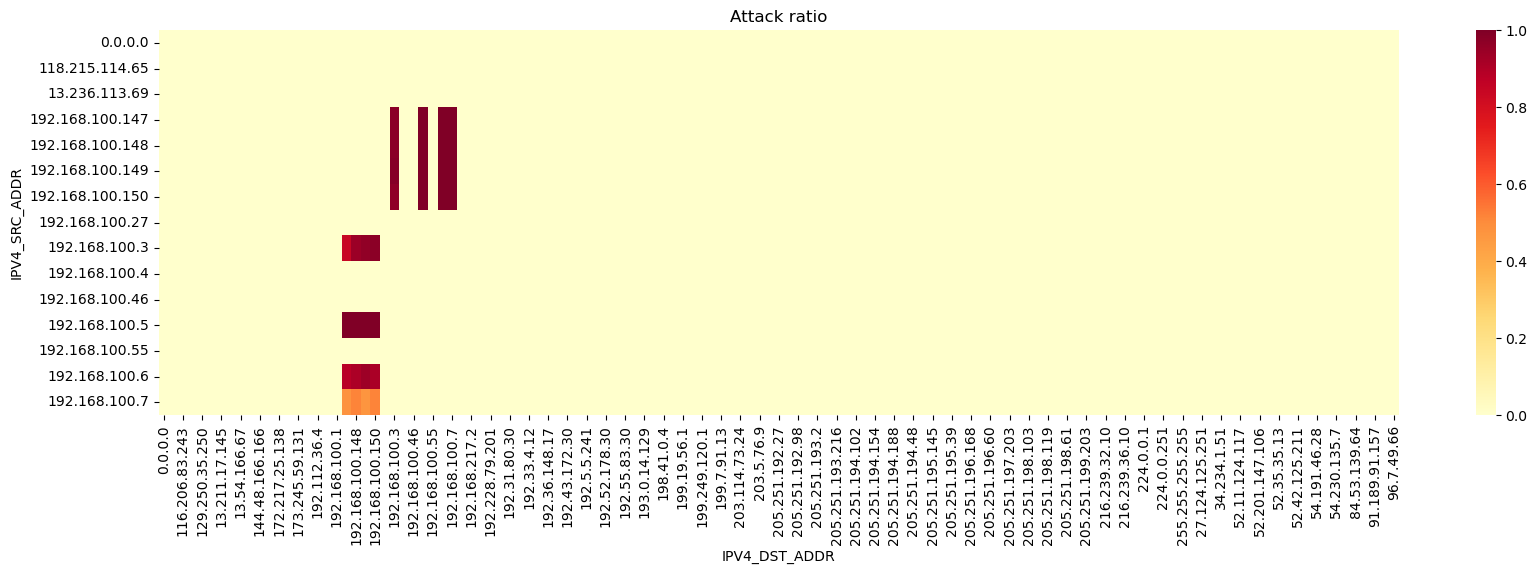

In [13]:
tmp_df = data.pivot_table(
    index='IPV4_SRC_ADDR', columns='IPV4_DST_ADDR', values='Label', aggfunc='mean', fill_value=0)
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(data=tmp_df, cmap='YlOrRd', ax=ax, annot=False, cbar=True)
ax.set_title(f'Attack ratio')
plt.show()

In [19]:
tmp_df

IPV4_DST_ADDR,0.0.0.0,101.119.11.11,101.119.11.17,101.119.11.209,101.119.11.8,101.119.56.250,103.1.213.38,103.102.166.224,103.126.53.123,103.126.53.26,...,96.7.50.192,96.7.50.32,96.7.50.66,97.74.106.27,97.74.111.53,97.74.96.100,97.74.97.102,98.124.250.87,99.99.99.130,99.99.99.132
IPV4_SRC_ADDR,,,,,,,,,,,,,,,,,,,,,
0.0.0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.246.69.149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.246.69.151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10.36.22.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101.114.0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88.221.81.192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91.189.91.139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91.189.91.157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## NF-ToN-IoT

In [41]:
dataset_name = 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}.csv'))
print('Number of samples:', data.shape[0])

Number of samples: 1379274


In [42]:
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign


In [43]:
for cname in cat_cnames:
    print(cname, data[cname].nunique())

TCP_FLAGS 24
L7_PROTO 97
PROTOCOL 5


In [23]:
print(data['Label'].value_counts())
print(data['Attack'].value_counts())

1    1108995
0     270279
Name: Label, dtype: int64
injection     468539
ddos          326345
Benign        270279
password      156299
xss            99944
scanning       21467
dos            17717
backdoor       17247
mitm            1295
ransomware       142
Name: Attack, dtype: int64


In [24]:
src_ip = data['IPV4_SRC_ADDR'].unique().tolist()
dst_ip = data['IPV4_DST_ADDR'].unique().tolist()
intersection_ip = set(src_ip).intersection(set(dst_ip))
print('Number of src:', len(src_ip))
print('Number of dst:', len(dst_ip))
print('Number of intersections:', len(intersection_ip))

Number of src: 174
Number of dst: 1478
Number of intersections: 151


In [25]:
src_port = data['L4_SRC_PORT'].unique().tolist()
dst_port = data['L4_DST_PORT'].unique().tolist()
intersection_port = set(src_port).intersection(set(dst_port))
print('Number of src:', len(src_port))
print('Number of dst:', len(dst_port))
print('Number of intersections:', len(intersection_port))

Number of src: 38857
Number of dst: 16071
Number of intersections: 15980


In [26]:
df_src = data.pivot_table(
    index='IPV4_SRC_ADDR', columns=['Label'], values='IPV4_DST_ADDR', aggfunc='count').fillna(0)
df_src['Total'] = df_src.sum(axis=1)
for c in df_src.columns:
    if c!='Total':
        df_src[c] = df_src[c] / df_src['Total']
df_src.sort_values('Total', ascending=False).head(20)

Label,0,1,Total
IPV4_SRC_ADDR,,,
192.168.1.31,0.000100,0.999900,269925.0
192.168.1.30,0.000007,0.999993,268910.0
192.168.1.36,0.000004,0.999996,244364.0
192.168.1.33,0.052702,0.947298,195761.0
192.168.1.184,1.000000,0.000000,112992.0
192.168.1.38,0.000000,1.000000,62848.0
192.168.1.35,0.000000,1.000000,59632.0
192.168.1.195,1.000000,0.000000,38983.0
192.168.1.190,1.000000,0.000000,32669.0


In [27]:
df_src = data.pivot_table(
    index='IPV4_SRC_ADDR', columns=['Attack'], values='IPV4_DST_ADDR', aggfunc='count').fillna(0)
df_src['Total'] = df_src.sum(axis=1)
for c in df_src.columns:
    if c!='Total':
        df_src[c] = df_src[c] / df_src['Total']
df_src.sort_values('Total', ascending=False).head(20)

Attack,Benign,backdoor,ddos,dos,injection,mitm,password,ransomware,scanning,xss,Total
IPV4_SRC_ADDR,,,,,,,,,,,
192.168.1.31,0.000100,0.000000,0.571399,0.032072,0.187419,0.002597,0.146848,0.000000,0.059565,0.000000,269925.0
192.168.1.30,0.000007,0.000000,0.564843,0.033692,0.240118,0.000000,0.141352,0.000000,0.019988,0.000000,268910.0
192.168.1.36,0.000004,0.000000,0.000000,0.000000,0.665352,0.000000,0.000000,0.000000,0.000000,0.334644,244364.0
192.168.1.33,0.052702,0.000792,0.000000,0.000000,0.641185,0.000000,0.305061,0.000261,0.000000,0.000000,195761.0
192.168.1.184,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,112992.0
192.168.1.38,0.000000,0.000000,0.319835,0.000000,0.561991,0.000000,0.117951,0.000000,0.000223,0.000000,62848.0
192.168.1.35,0.000000,0.000000,0.000000,0.000000,0.502163,0.000000,0.193151,0.000000,0.000000,0.304685,59632.0
192.168.1.195,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38983.0
192.168.1.190,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32669.0


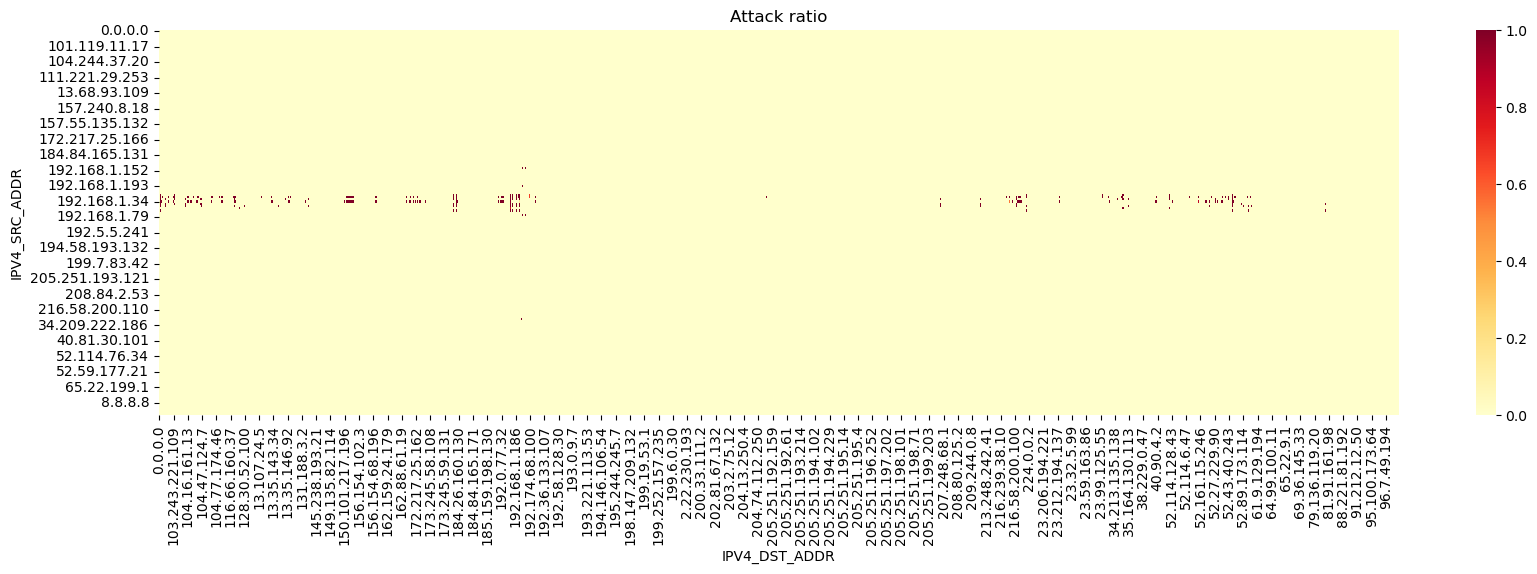

In [28]:
tmp_df = data.pivot_table(
    index='IPV4_SRC_ADDR', columns='IPV4_DST_ADDR', values='Label', aggfunc='mean', fill_value=0)
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(data=tmp_df, cmap='YlOrRd', ax=ax, annot=False, cbar=True)
ax.set_title(f'Attack ratio')
plt.show()

# Split data

In [95]:
def get_tvt(data, label_cname='Label', tvt_ratio=(0.5,0.2,0.3), seed=2022):
    assert sum(tvt_ratio) == 1, "Incorrect train/val/test ratio"
    df_tvt = data.copy()
    tvt_cname = f'{label_cname}_tvt'
    df_tvt[tvt_cname] = 'Other'
    # get si
    val_ratio = tvt_ratio[1]
    test_ratio = tvt_ratio[2]
    n_samples = data.shape[0]
    n_test = int(n_samples*test_ratio) 
    n_val = int(n_samples*val_ratio) 
    n_train = n_samples - n_val - n_test
    print('n_train:', n_train)
    print('n_val:', n_val)
    print('n_test:', n_test)
    # get test indices
    X = df_tvt[df_tvt[tvt_cname]=='Other'].index.values
    y = df_tvt[df_tvt[tvt_cname]=='Other'].Label.values
    X_train, X_test, _, _ = train_test_split(
        X, y, test_size=n_test, shuffle=True, stratify=y, random_state=seed)
    df_tvt.loc[X_test, tvt_cname] = 'test'
    # get val indices
    X = df_tvt[df_tvt[tvt_cname]=='Other'].index.values
    y = df_tvt[df_tvt[tvt_cname]=='Other'].Label.values
    X_train, X_val, _, _ = train_test_split(
        X, y, test_size=n_val, shuffle=True, stratify=y, random_state=seed)
    df_tvt.loc[X_val, tvt_cname] = 'val'
    df_tvt.loc[X_train, tvt_cname] = 'train'
    return df_tvt

In [96]:
ds_names = ['NF-BoT-IoT', 'NF-ToN-IoT']
for dataset_name in ds_names:
    print(dataset_name)
    data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}.csv'))
    data = get_tvt(data, label_cname='Label')
    data = get_tvt(data, label_cname='Attack')
    data.to_csv(str(PROJ_PATH / f'datasets/{dataset_name}_tvt.csv'), index=False)
    #
    print(data.pivot_table(index='Label_tvt', columns='Label', values='IPV4_SRC_ADDR', aggfunc='count'))
    print(data.pivot_table(index='Attack_tvt', columns='Attack', values='IPV4_SRC_ADDR', aggfunc='count'))
    print('\n')

NF-BoT-IoT
n_train: 300050
n_val: 120020
n_test: 180030
n_train: 300050
n_val: 120020
n_test: 180030
Label         0       1
Label_tvt              
test       4158  175872
train      6929  293121
val        2772  117248
Attack      Benign   DDoS    DoS  Reconnaissance  Theft
Attack_tvt                                             
test          4158  17012  17175          141137    548
train         6929  28513  28295          235339    974
val           2772  11319  11363           94179    387


NF-ToN-IoT
n_train: 689638
n_val: 275854
n_test: 413782
n_train: 689638
n_val: 275854
n_test: 413782
Label           0       1
Label_tvt                
test        81084  332698
train      135139  554499
val         54056  221798
Attack      Benign  backdoor    ddos   dos  injection  mitm  password  \
Attack_tvt                                                              
test         81084      5186   98159  5364     140280   395     46867   
train       135139      8604  162915  8812     

# Preprocess data

In [2]:
def preprocess_data(data, label_cname='Label'):
    '''
    Extract graph data:
        - node_features: [num_nodes, num_node_features]
        - node_labels: [num_nodes, 1]
        - edge_index: [2, num_edges]
        - edge_attr: [num_edges, num_edge_features]
        - edge_label: [num_edges, 1]
    '''
    data['IPV4_SRC_FULL_ADDR'] = data['IPV4_SRC_ADDR'].astype(str) + ':' + data['L4_SRC_PORT'].astype(str)
    data['IPV4_DST_FULL_ADDR'] = data['IPV4_DST_ADDR'].astype(str) + ':' + data['L4_DST_PORT'].astype(str)
    tvt_cname = f'{label_cname}_tvt'
    label_groups = sorted(data[label_cname].unique().tolist())
    cat_cols = ['TCP_FLAGS','L7_PROTO','PROTOCOL']

    #
    nodes = sorted(set(data['IPV4_SRC_FULL_ADDR'].unique().tolist() + data['IPV4_DST_FULL_ADDR'].unique().tolist()))
    node2nid = {j:i for i,j in enumerate(nodes)}
    data['src_nid'] = data['IPV4_SRC_FULL_ADDR'].map(node2nid)
    data['dst_nid'] = data['IPV4_DST_FULL_ADDR'].map(node2nid)
    data_01 = data.copy()
    i_train = (data_01[tvt_cname]!='test')
    df_nid = pd.DataFrame({'nid': node2nid.values()})
    # 1. Get node features
    src_cnames = ['IPV4_SRC_ADDR', 'IPV4_SRC_FULL_ADDR']
    dst_cnames = ['IPV4_DST_ADDR', 'IPV4_DST_FULL_ADDR']
    ## 
    df_feature_list = []
    for grp in label_groups[1:]:
        print(grp)
        data_01[f'label_{grp}'] = (data_01[label_cname]==grp).astype(int)
        ## 
        encoder01 = ce.TargetEncoder(cols=src_cnames, handle_unknown=0)
        encoder01.fit(data_01.loc[i_train], data_01.loc[i_train, f'label_{grp}'])
        df_src_feature01 = encoder01.transform(data_01)[['src_nid']+src_cnames].drop_duplicates()
        df_src_feature01.columns = ['nid'] + [f'{fn}_ratio_{grp}' for fn in src_cnames]
        ## 
        encoder02 = ce.count.CountEncoder(cols=src_cnames, handle_unknown=0)
        encoder02.fit(data_01.loc[i_train], data_01.loc[i_train, f'label_{grp}'])
        df_src_feature02 = encoder02.transform(data_01)[['src_nid']+src_cnames].drop_duplicates()
        df_src_feature02.columns = ['nid'] + [f'{fn}_freq_{grp}' for fn in src_cnames]
        ## 
        encoder03 = ce.TargetEncoder(cols=dst_cnames, handle_unknown=0)
        encoder03.fit(data_01.loc[i_train], data_01.loc[i_train, f'label_{grp}'])
        df_dst_feature03 = encoder03.transform(data_01)[['dst_nid']+dst_cnames].drop_duplicates()
        df_dst_feature03.columns = ['nid'] + [f'{fn}_ratio_{grp}' for fn in dst_cnames]
        ## 
        encoder04 = ce.count.CountEncoder(cols=dst_cnames, handle_unknown=0)
        encoder04.fit(data_01.loc[i_train], data_01.loc[i_train, f'label_{grp}'])
        df_dst_feature04 = encoder04.transform(data_01)[['dst_nid']+dst_cnames].drop_duplicates()
        df_dst_feature04.columns = ['nid'] + [f'{fn}_freq_{grp}' for fn in dst_cnames]
        ##
        df_feature_list += [df_src_feature01, df_src_feature02, df_dst_feature03, df_dst_feature04]
    ##
    df_nid = pd.DataFrame({'nid': node2nid.values()})
    df_node_features = df_nid.copy()
    for tdf in df_feature_list:
        df_node_features = df_node_features.merge(tdf, on='nid', how='left')
    df_node_features = df_node_features.fillna(0.0)
    nf_cnames = sorted([c for c in df_node_features.columns if c != 'nid'])

    # 2. Get edge features
    ef_cnames = [
        'FLOW_DURATION_MILLISECONDS',
        'IN_BYTES',
        'IN_PKTS',
        'L7_PROTO',
        'OUT_BYTES',
        'OUT_PKTS',
        'PROTOCOL',
        'TCP_FLAGS',
    ]
    encoder05 = ce.TargetEncoder(cols=cat_cols, handle_unknown=0)
    encoder05.fit(data_01.loc[i_train], data_01.loc[i_train, 'Label'])
    df_e_features = encoder05.transform(data_01)[ef_cnames].fillna(0.0)

    # 3. Normalize feature
    ##
    scaler_n = StandardScaler()
    scaler_n.fit(df_node_features[nf_cnames])
    n_features = scaler_n.transform(df_node_features[nf_cnames])
    ##
    scaler_e = StandardScaler()
    scaler_e.fit(df_e_features.loc[i_train])
    e_features = scaler_e.transform(df_e_features)

    # 4. Get edge indices
    src_idx = data_01['src_nid'].values.tolist()
    dst_idx = data_01['dst_nid'].values.tolist()
    edge_index = np.array([src_idx, dst_idx])

    # 5. Get edge label
    label2idx = {j:i for i,j in enumerate(label_groups)}
    print(label2idx)
    edge_label = data_01[label_cname].map(label2idx).values

    # 6. Get node label
    df_node_features['bad_ratio'] = df_node_features[[
        c for c in df_node_features.columns if c.startswith('IPV4_SRC_ADDR_')]].sum(axis=1)
    node_label = (df_node_features['bad_ratio']>=0.5).values.astype(int)
    
    # 7. Get tvt
    tvt = data_01[tvt_cname].values
    return n_features, e_features, edge_index, edge_label, node_label, tvt, label2idx

In [3]:
dataset_name = 'NF-BoT-IoT' # 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}_tvt.csv'))
print('Number of samples:', data.shape[0])
n_features, e_features, edge_index, edge_label, node_label, tvt, label2idx = preprocess_data(
    data, label_cname='Attack')
print(n_features.shape, e_features.shape, edge_index.shape, edge_label.shape, node_label.shape, len(tvt))
g_data = {
    'n_features': n_features, 
    'e_features': e_features, 
    'edge_index': edge_index, 
    'edge_label': edge_label, 
    'node_label': node_label, 
    'tvt': tvt, 
    'label2idx': label2idx, 
}
f_name = str(PROJ_PATH / f'datasets/{dataset_name}_graph_multi.pkl')
print(f_name)
pd.to_pickle(g_data, f_name)

Number of samples: 600100
DDoS
DoS
Reconnaissance
Theft
{'Benign': 0, 'DDoS': 1, 'DoS': 2, 'Reconnaissance': 3, 'Theft': 4}
(77177, 32) (600100, 8) (2, 600100) (600100,) (77177,) 600100
/home/hoang/github/TS-IDS/datasets/NF-BoT-IoT_graph_multi.pkl


In [4]:
dataset_name = 'NF-BoT-IoT' # 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}_tvt.csv'))
print('Number of samples:', data.shape[0])
n_features, e_features, edge_index, edge_label, node_label, tvt, label2idx = preprocess_data(
    data, label_cname='Label')
print(n_features.shape, e_features.shape, edge_index.shape, edge_label.shape, node_label.shape, len(tvt))
g_data = {
    'n_features': n_features, 
    'e_features': e_features, 
    'edge_index': edge_index, 
    'edge_label': edge_label, 
    'node_label': node_label, 
    'tvt': tvt, 
    'label2idx': label2idx, 
}
f_name = str(PROJ_PATH / f'datasets/{dataset_name}_graph_binary.pkl')
print(f_name)
pd.to_pickle(g_data, f_name)

Number of samples: 600100
1
{0: 0, 1: 1}
(77177, 8) (600100, 8) (2, 600100) (600100,) (77177,) 600100
/home/hoang/github/TS-IDS/datasets/NF-BoT-IoT_graph_binary.pkl


In [5]:
dataset_name = 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}_tvt.csv'))
print('Number of samples:', data.shape[0])
n_features, e_features, edge_index, edge_label, node_label, tvt, label2idx = preprocess_data(
    data, label_cname='Attack')
print(n_features.shape, e_features.shape, edge_index.shape, edge_label.shape, node_label.shape, len(tvt))
g_data = {
    'n_features': n_features, 
    'e_features': e_features, 
    'edge_index': edge_index, 
    'edge_label': edge_label, 
    'node_label': node_label, 
    'tvt': tvt, 
    'label2idx': label2idx, 
}
f_name = str(PROJ_PATH / f'datasets/{dataset_name}_graph_multi.pkl')
print(f_name)
pd.to_pickle(g_data, f_name)

Number of samples: 1379274
backdoor
ddos
dos
injection
mitm
password
ransomware
scanning
xss
{'Benign': 0, 'backdoor': 1, 'ddos': 2, 'dos': 3, 'injection': 4, 'mitm': 5, 'password': 6, 'ransomware': 7, 'scanning': 8, 'xss': 9}
(169562, 72) (1379274, 8) (2, 1379274) (1379274,) (169562,) 1379274
/home/hoang/github/TS-IDS/datasets/NF-ToN-IoT_graph_multi.pkl


In [6]:
dataset_name = 'NF-ToN-IoT'
data = pd.read_csv(str(PROJ_PATH / f'datasets/{dataset_name}_tvt.csv'))
print('Number of samples:', data.shape[0])
n_features, e_features, edge_index, edge_label, node_label, tvt, label2idx = preprocess_data(
    data, label_cname='Label')
print(n_features.shape, e_features.shape, edge_index.shape, edge_label.shape, node_label.shape, len(tvt))
g_data = {
    'n_features': n_features, 
    'e_features': e_features, 
    'edge_index': edge_index, 
    'edge_label': edge_label, 
    'node_label': node_label, 
    'tvt': tvt, 
    'label2idx': label2idx, 
}
f_name = str(PROJ_PATH / f'datasets/{dataset_name}_graph_binary.pkl')
print(f_name)
pd.to_pickle(g_data, f_name)

Number of samples: 1379274
1
{0: 0, 1: 1}
(169562, 8) (1379274, 8) (2, 1379274) (1379274,) (169562,) 1379274
/home/hoang/github/TS-IDS/datasets/NF-ToN-IoT_graph_binary.pkl


In [7]:
!ls /home/hoang/github/TS-IDS/datasets/

NF-BoT-IoT.csv		     NF-ToN-IoT.csv
NF-BoT-IoT_graph_binary.pkl  NF-ToN-IoT_graph_binary.pkl
NF-BoT-IoT_graph_multi.pkl   NF-ToN-IoT_graph_multi.pkl
NF-BoT-IoT_tvt.csv	     NF-ToN-IoT_tvt.csv
